# Jupyter notebook to generate the data and plot Figure 2 in "Heat extremes driven by amplification of phase-locked circumglobal waves forced by topography in an idealized atmospheric model" by B. Jimenez-Esteve, K. Kornhuber and D. I.V. Domeisen

Author: Bernat Jimenez-Esteve (ETH Zurich) Last update: October 2022

The notebook blocks need to be executed sequencially in order to be able to reproduce the same Figures as in the paper.

The netCDF files containing the processed model data can be downloaded from the following repository:

In [1]:
#load main modeules
import xarray as xr
import numpy as np

exec(open('src/hayashi_spectra.py').read())

In [2]:
#choose lat band
lat_band = slice(60,30)

## Load model data

#### NO-TOPO run

In [3]:
#Read ICON data
f = 'data/daily/u300_v300_z300_t1000_heldsuarez_notopo_daymean.nc'
v300_hs =  xr.open_mfdataset(f).v300.sel(lat=lat_band, time=slice('0001-01-01', '0030-12-30')).load()

v300_hs = v300_hs.rename({'lat': 'latitude', 'lon': 'longitude'})

## 1. Calculate Hayashi spectra

In [4]:
def daily_anom(daily_var,clim=False):
    #daily climatology 
    var_clim = daily_var.groupby('time.dayofyear').mean('time').load()
    #daymean anomalies
    var_anom = daily_var.groupby('time.dayofyear') - var_clim
    if(clim==True):
        return var_anom, var_clim
    else:
        return var_anom

In [5]:
v_anom = daily_anom(v300_hs)

# produce frequency-wavenumber spectrum
spect = wavenum_freq_spect(v300_hs)

# turn into phase speed-wavenumber spectrum
dc = 0.3 #delta phase speed in m/s
cmax = 30 #maximum phase-speed to consider [-30 to 30 m/s]
spect_c = freq2phase_speed(spect,dc=dc,cmax=cmax)
    
# average of latitudes
spect_c = spect_c.mean('latitude')


 Time-mean, zonal-mean variance
<xarray.DataArray 'v300' (latitude: 16)>
array([ 95.39151 , 113.637886, 138.68463 , 171.61253 , 212.61343 ,
       260.18192 , 310.76477 , 358.78976 , 397.62927 , 421.14008 ,
       425.4045  , 409.64325 , 376.31995 , 330.34418 , 277.66757 ,
       224.04228 ], dtype=float32)
Coordinates:
    plev      float64 3e+04
  * latitude  (latitude) float64 58.76 56.89 55.02 53.16 ... 34.51 32.64 30.78

 Variance retainded by integration over frequency and wavenumber
<xarray.DataArray (latitude: 16)>
array([ 79.33383389,  89.33416828, 105.50303197, 126.61766574,
       151.51524185, 184.18391778, 227.8135928 , 277.49198157,
       321.96088973, 350.37931202, 358.34433578, 347.10333715,
       321.18943414, 286.42788976, 246.49629699, 202.39178421])
Coordinates:
    plev      float64 3e+04
  * latitude  (latitude) float64 58.76 56.89 55.02 53.16 ... 34.51 32.64 30.78

 Variance retainded by integration over phase speed and wavenumber
<xarray.DataArray (latitude: 

/home/bernatj/.conda/envs/ncl_to_python/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [6]:
import metpy.calc as mpcalc

#perform smoothing of the spectra to remove the noise
spect_c_sm = mpcalc.smooth_rectangular(spect_c, (5, 3), 2).metpy.dequantify() 

# 2. Plotting of the spectra

In [7]:
#theoretical phase speed of wave of a 7 day period (to plot overlay)
a = 6371000
k=np.arange(1,15,1)
c_7d = 2*np.pi*np.cos(45./180.*np.pi)*a/(7*3600*24)/k

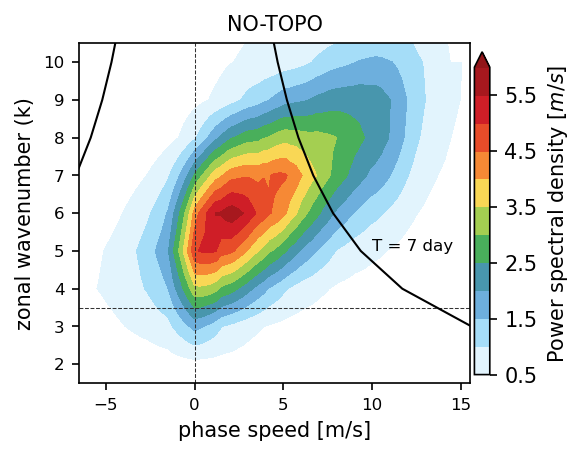

In [8]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmaps 

#to make the plot larger
plt.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = 4,3

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(1)

ax.set_xticks(np.arange(-15,16,5));
ax.set_yticks(np.arange(0,11,1));
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xlim([-6.5, 15.5])
ax.set_ylim([1.5, 10.5])

ax.axvline(0, color='0.2',ls="--", lw=0.5)
ax.axhline(3.5, color='0.2',ls="--", lw=0.5)

ax.set_title('NO-TOPO', fontsize=10)
ax.set_xlabel('phase speed [m/s]')
ax.set_ylabel('zonal wavenumber (k)')

cmap1 = cmaps.WhiteBlueGreenYellowRed

levels= (np.arange(0.5,6.1,0.5))
ls=['--','--','--','--','--','-','-','-','-','-']
lw=1.0

h = ax.contourf(spect_c.phase_speed, spect_c.wavenumber, spect_c_sm.transpose('wavenumber','phase_speed'), levels=levels, cmap=cmap1, extend='max', alpha=1.0)

h2 = ax.plot(c_7d, k, color='k',lw=1.0)
h2 = ax.plot(-c_7d, k, color='k',lw=1.0)
tx = ax.text(10, 5, 'T = 7 day', color='k', size=8)

# add common colorbar
cbar = plt.colorbar(h, ax=ax, label='Power spectral density [$m/s$]',pad=0.01, orientation='vertical',shrink=0.95,aspect=20)

#save figure
plt.savefig('figures/hayashi_spectra_v300_HS_notopo.pdf',bbox_inches='tight')

## 3. Difference plots between simulations

#### TOPO run: select the file where to find v300

Change below the name of the run you want to compare to the no-topo run.
You need to adapt the the figure title and name at the end

In [10]:
#Read ICON data
sim_name = 'u300_v300_z300_t1000_heldsuarez_topo_4km_45N_daymean.nc'

f = f'data/daily/{sim_name}'
v300_hs_topo =  xr.open_dataset(f).v300.sel(lat=lat_band,time=slice('0001-01-01', '0030-12-30')).load()
v300_hs_topo = v300_hs_topo.rename({'lat': 'latitude', 'lon': 'longitude'})

In [11]:
# caculate anomalies
v1_anom = daily_anom(v300_hs)
v2_anom = daily_anom(v300_hs_topo)

In [12]:
# produce frequency-wavenumber spectrum
spect1 = wavenum_freq_spect(v1_anom)
spect2 = wavenum_freq_spect(v2_anom)

# turn into phase speed-wavenumber spectrum
spect1_c = freq2phase_speed(spect1,dc=0.3,cmax=30)
spect2_c = freq2phase_speed(spect2,dc=0.3,cmax=30)

# average of latitudes
spect1_c = spect1_c.mean('latitude')
spect2_c = spect2_c.mean('latitude')


 Time-mean, zonal-mean variance
<xarray.DataArray 'v300' (latitude: 16)>
array([ 92.23749, 109.88021, 134.05928, 165.79247, 205.25488, 251.01193,
       299.67188, 345.90634, 383.34906, 406.07053, 410.2712 , 395.17538,
       363.13257, 318.86624, 268.11392, 216.41405], dtype=float32)
Coordinates:
    plev      float64 3e+04
  * latitude  (latitude) float64 58.76 56.89 55.02 53.16 ... 34.51 32.64 30.78

 Variance retainded by integration over frequency and wavenumber
<xarray.DataArray (latitude: 16)>
array([ 82.73489534,  95.22830939, 113.35233699, 137.30350713,
       166.82021759, 206.16649703, 257.11246436, 310.75911739,
       356.65114405, 385.64281234, 391.04775189, 374.09516978,
       342.16125125, 301.81811035, 256.72544099, 210.07062635])
Coordinates:
    plev      float64 3e+04
  * latitude  (latitude) float64 58.76 56.89 55.02 53.16 ... 34.51 32.64 30.78

 Time-mean, zonal-mean variance
<xarray.DataArray 'v300' (latitude: 16)>
array([103.57239388, 118.01387825, 136.9440845

/home/bernatj/.conda/envs/ncl_to_python/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [13]:
import metpy.calc as mpcalc

spect1_c_sm = mpcalc.smooth_rectangular(spect1_c, (5, 3), 2).metpy.dequantify() 
spect2_c_sm = mpcalc.smooth_rectangular(spect2_c, (5, 3), 2).metpy.dequantify() 

In [14]:
#difference
spect_diff = spect2_c_sm -spect1_c_sm

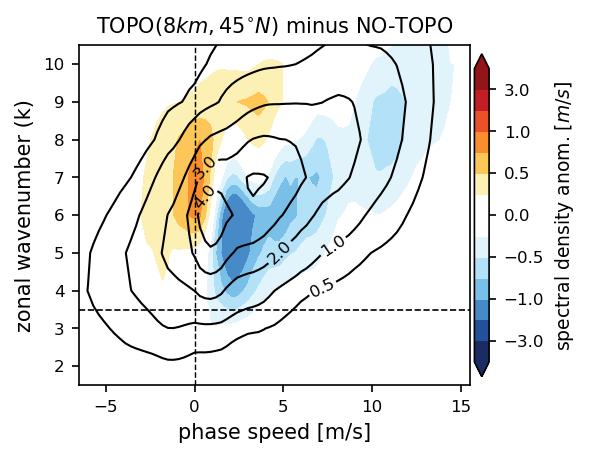

In [15]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmaps 

#to make the plot larger
plt.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = 4,3

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(1)

ax.set_xticks(np.arange(-15,16,5));
ax.set_yticks(np.arange(0,11,1));
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xlim([-6.5, 15.5])
ax.set_ylim([1.5, 10.5])

ax.axvline(0, color='k',ls="--", lw=0.7)
ax.axhline(3.5, color='k',ls="--", lw=0.8)

#Title needs to be adapted
#ax.set_title('ICON Held-Suarez topo ($H=8 km , \phi_0 = 25^{\circ}N$)', fontsize=10)
ax.set_title('TOPO($8km,45^{\circ}N$) minus NO-TOPO', fontsize=10)
ax.set_xlabel('phase speed [m/s]')
ax.set_ylabel('zonal wavenumber (k)')


cmap1 = cmaps.BlueWhiteOrangeRed
levels= [-4,-3,-2,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,2,3,4]
norm = colors.BoundaryNorm(boundaries=levels, ncolors=256)


h = ax.contourf(spect1_c.phase_speed, spect1_c.wavenumber, spect_diff.transpose('wavenumber','phase_speed'),
                cmap=cmap1, extend='both', levels=levels, norm=norm, alpha=1.0)
h1 = ax.contour(spect1_c.phase_speed, spect1_c.wavenumber, spect2_c_sm.transpose('wavenumber','phase_speed'),
                colors='k', levels = [0.5,1,2,3,4], linewidths=1.0)
c1 = ax.clabel(h1,fmt='%1.1f',fontsize=8,colors='k',inline_spacing=2.5, use_clabeltext=True)

# add common colorbar
cbar = plt.colorbar(h, ax=ax, pad=0.01, orientation='vertical',shrink=0.95,aspect=20)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(label='spectral density anom. [$m/s$]',size=9)

#save figure (adapt the title)
plt.savefig('figures/hayashi_spectra_HS_diff_notopo_and_4km45N.pdf',bbox_inches='tight')